# Initial imports

In [664]:
# Numeric and data processing
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
from pandas.api.types import CategoricalDtype

# sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.metrics import make_scorer
from scipy.stats import ks_2samp
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, chi2, SelectKBest

# plotting
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

%matplotlib inline

In [ ]:
# Global random state for reproducibility
random_state_global = 42

# Dataprep

## Reading data from csv

8. Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques. 

In [ ]:
df_full = pd.read_csv('../data/bank-additional/bank-additional-full.csv', sep=';', na_values=['unknown'])
df_full.columns = df_full.columns.str.replace('.', '_')

In [ ]:
df_full.head()

In [ ]:
# Is there missing values on data? YES, I forced it using a_values=['unknown'] using 
df_full.isnull().sum()

## Categorical and numeric data preprocessing

## Categorical data

Some categorical have a meaningful ordering, like education ('basic.4y' < 'basic.6y',  ...) and default ('yes' > 'no'). For these
we will use this information while creating the category data type; for the others, there is no meaningful order, and we will not specify order while creating the category data type.

In [ ]:
# Frequency of categories for each categorical feature
for col in df_full.select_dtypes('O').columns:
    print('\n', col)
    print(df_full[col].value_counts(dropna=False))

## Downcasting numeric features to reduce memory usage
(inspired on https://www.kaggle.com/gemartin/load-data-reduce-memory-usage)

In [ ]:
# Dict storing datatypes of all features
dict_dtypes = {}

# Categorical features with meaningful ordering
dict_dtypes['education'] = CategoricalDtype(categories = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 
                                                          'professional.course', 'university.degree']
                                            , ordered=True)

dict_dtypes['default'] = CategoricalDtype(categories = ['no', 'yes'], ordered=True)
dict_dtypes['housing'] = CategoricalDtype(categories = ['no', 'yes'], ordered=True)
dict_dtypes['loan'] = CategoricalDtype(categories = ['no', 'yes'], ordered=True)
dict_dtypes['poutcome'] = CategoricalDtype(categories = ['failure', 'success'], ordered=True)# nonexistent considered as missing value
dict_dtypes['y'] = CategoricalDtype(categories = ['no', 'yes'], ordered=True)

# Polemic
dict_dtypes['day_of_week'] = CategoricalDtype(categories = ['mon', 'tue', 'wed', 'thu', 'fri'], ordered=True)
dict_dtypes['month'] = CategoricalDtype(categories = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug',
                                                     'sep', 'oct', 'nov', 'dec'], ordered=True)
# Other categorical features
for col in df_full.select_dtypes('O').columns:
    if col not in dict_dtypes.keys():
        dict_dtypes[col] = CategoricalDtype(categories = sorted(df_full[col].dropna().unique()), ordered=False)

In [ ]:
# Note: pandas alerady have nullable integer datatypes, but I will not use. If a integer column have at least a missing value,
# it will be converted to float32.
for col in df_full.select_dtypes(np.number):
    _vec_min_max = df_full[col].describe()[['min','max']]
    _has_null = df_full[col].isnull().max()
    _has_float = (df_full[col] % 1 != 0).any()
    
    if _has_float or _has_null:
        dict_dtypes[col] = pd.to_numeric(_vec_min_max, downcast='float').dtype
    else:
        if _vec_min_max[0] >=0:
            dict_dtypes[col] = pd.to_numeric(_vec_min_max, downcast='unsigned').dtype
        else:
            dict_dtypes[col] = pd.to_numeric(_vec_min_max, downcast='signed').dtype

start_memory_usage = df_full.memory_usage().sum() / 1024**2
end_memory_usage = df_full.astype(dict_dtypes).memory_usage().sum() / 1024**2

print('Initial memory usage: {:.2f} MB'.format(start_memory_usage))
print('Memory usage after optimization: {:.2f} MB'.format(end_memory_usage))
print('Memory usage decreased by {:.1f}%'.format(100 * (start_memory_usage - end_memory_usage) / start_memory_usage))

## Applying new dtypes inplace on initial dataframe

In [ ]:
df_full = df_full.astype(dict_dtypes)

# Modelling

## Train test split

In [450]:
# I used pd.get_dummies before splitting instead of including then on pipeline for simplicity
X_train, X_test, y_train, y_test = train_test_split(df_full.drop('y', axis=1), df_full['y'].cat.codes,
                                                    test_size=0.20, random_state=random_state_global)

In [451]:
num_cols = df_full.select_dtypes(np.number).columns.to_list()
cat_cols = df_full.drop(['y'], axis=1).select_dtypes('category').columns.to_list()

## KS and gini functions and sklearn scorers

In [ ]:
def ks_stat(y_true, y_proba):
#     As seen on https://medium.com/@xiaowei_6531/using-ks-stat-as-a-model-evaluation-metric-in-scikit-learns-gridsearchcv-33135101601c
    return ks_2samp(y_proba[y_true==1], y_proba[y_true!=1]).statistic

ks_scorer = make_scorer(ks_stat, needs_proba=True, greater_is_better=True)

#Remove redundant calls
def ginic(actual, pred):
    actual = np.asarray(actual) #In case, someone passes Series or list
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalizedc(a, p):
    if p.ndim == 2:#Required for sklearn wrapper
        p = p[:,1] #If proba array contains proba for both 0 and 1 classes, just pick class 1
    return ginic(a, p) / ginic(a, a)

gini_scorer = make_scorer(gini_normalizedc, needs_proba=True, greater_is_better=True)

## Basic pipeline

In [ ]:
# KFold for hyperparameter tuning and acessing model quality
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_global)

In [494]:
def get_cat_codes(X, return_df=True):
    if return_df:
        return X.apply(lambda x: x.cat.codes)
    else:
        return X.apply(lambda x: x.cat.codes).values

def from_cat_to_str(X):
    return X.astype(str)
    
def f_select_dtypes(X, dtype):
    return X.select_dtypes()

select_num_transformer = FunctionTransformer(lambda x: x.select_dtypes(np.number), validate=False)
select_cat_transformer = FunctionTransformer(lambda x: x.select_dtypes('category'), validate=False)
get_cat_codes_transformer = FunctionTransformer(get_cat_codes, validate=False)
from_cat_to_str_transformer = FunctionTransformer(from_cat_to_str, validate=False)

In [ ]:
# If would like to use OneHotEncoder inside pipeline (NOT USED, just for reference!!!)
# Using sklearn pipelines
linear_model_pipeline = FeatureUnion([
    ('num_feat', make_pipeline(select_num_transformer ,StandardScaler())),
    ('cat_feat', make_pipeline(select_cat_transformer ,get_cat_features_transformer, OneHotEncoder(sparse=False, handle_unknown='ignore', categories='auto')))
     ])

# Using DataFrameMapper from sklearn_pandas (Using OneHotEncoder instead of pd.get_dummies)
# TODO: remove x0 on feature encoded on OneHotEncoder
mapper = DataFrameMapper(
    [([col], StandardScaler()) for col in num_cols] + 
    [([col], [get_cat_features_transformer, OneHotEncoder(dtype=np.int8, sparse=False, handle_unknown='ignore', categories='auto')]) for col in cat_cols]
     , input_df=True, df_out=True)
# mapper.fit_transform(df_full)

# Metrics for models

In [500]:
# Generic Pipeline
num_pipe = Pipeline(steps=[('scaler', None)])
cat_pipe = Pipeline(steps=[('cat_imputer', SimpleImputer(strategy='constant', fill_value='cat_missing')),
                           ('cat_encoder_1', None), ('cat_encoder_2', None)])

feat_pipe = ColumnTransformer(
    transformers=[
        ('cat', cat_pipe, cat_cols),
        ('num', num_pipe, num_cols)])

clf = Pipeline(steps=[('feat_pipe', feat_pipe),
                      ('classifier', None)])


In [601]:
param_grid = [
# #     Logistic regression
    {
        'feat_pipe__num__scaler': [StandardScaler()],
        'feat_pipe__cat__cat_encoder_1': [from_cat_to_str_transformer],
        'feat_pipe__cat__cat_encoder_2': [OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore', dtype=np.uint8)],
        'classifier': [LogisticRegression(random_state=random_state_global, max_iter=1000, penalty='elasticnet',
                                          solver='saga',class_weight='balanced', n_jobs=10)],
        'classifier__l1_ratio': [0, 0.5, 1]
    }
,
#     Random Forest

#      {
#          'feat_pipe__num__scaler': [None],
#          'feat_pipe__cat__cat_encoder_1': [None],
#          'feat_pipe__cat__cat_encoder_2': [OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore', dtype=np.uint8)],
#          'classifier': [RandomForestClassifier(n_jobs=10, n_estimators=500)],
#          'classifier__class_weight': ['balanced', 'balanced_subsample']
#     }
]
    
param_grid
gs = GridSearchCV(cv=kf, param_grid=param_grid, estimator=clf, n_jobs=1, scoring=ks_scorer, verbose=2, return_train_score=True)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] classifier=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=10,
                   penalty='elasticnet', random_state=42, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False), classifier__l1_ratio=0, feat_pipe__cat__cat_encoder_1=FunctionTransformer(accept_sparse=False, check_inverse=True,
                    func=<function from_cat_to_str at 0x000001E59BA580D8>,
                    inv_kw_args=None, inverse_func=None, kw_args=None,
                    pass_y='deprecated', validate=False), feat_pipe__cat__cat_encoder_2=OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.uint8'>, handle_unknown='ignore',
              n_values=None, sparse=False), feat_pipe__num__scaler=StandardScaler(copy=True, with_m

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=10,
                   penalty='elasticnet', random_state=42, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False), classifier__l1_ratio=0, feat_pipe__cat__cat_encoder_1=FunctionTransformer(accept_sparse=False, check_inverse=True,
                    func=<function from_cat_to_str at 0x000001E59BA580D8>,
                    inv_kw_args=None, inverse_func=None, kw_args=None,
                    pass_y='deprecated', validate=False), feat_pipe__cat__cat_encoder_2=OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.uint8'>, handle_unknown='ignore',
              n_values=None, sparse=False), feat_pipe__num__scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total=   5.0s
[CV] classifier=Log

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV]  classifier=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0,
                   max_iter=1000, multi_class='warn', n_jobs=10,
                   penalty='elasticnet', random_state=42, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False), classifier__l1_ratio=0, feat_pipe__cat__cat_encoder_1=FunctionTransformer(accept_sparse=False, check_inverse=True,
                    func=<function from_cat_to_str at 0x000001E59BA580D8>,
                    inv_kw_args=None, inverse_func=None, kw_args=None,
                    pass_y='deprecated', validate=False), feat_pipe__cat__cat_encoder_2=OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.uint8'>, handle_unknown='ignore',
              n_values=None, sparse=False), feat_pipe__num__scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total=   6.4s
[CV] classifier=Logist

[CV]  classifier=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.5,
                   max_iter=1000, multi_class='warn', n_jobs=10,
                   penalty='elasticnet', random_state=42, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False), classifier__l1_ratio=0.5, feat_pipe__cat__cat_encoder_1=FunctionTransformer(accept_sparse=False, check_inverse=True,
                    func=<function from_cat_to_str at 0x000001E59BA580D8>,
                    inv_kw_args=None, inverse_func=None, kw_args=None,
                    pass_y='deprecated', validate=False), feat_pipe__cat__cat_encoder_2=OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.uint8'>, handle_unknown='ignore',
              n_values=None, sparse=False), feat_pipe__num__scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total=  13.8s
[CV] classifier=Lo

[CV]  classifier=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=1,
                   max_iter=1000, multi_class='warn', n_jobs=10,
                   penalty='elasticnet', random_state=42, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False), classifier__l1_ratio=1, feat_pipe__cat__cat_encoder_1=FunctionTransformer(accept_sparse=False, check_inverse=True,
                    func=<function from_cat_to_str at 0x000001E59BA580D8>,
                    inv_kw_args=None, inverse_func=None, kw_args=None,
                    pass_y='deprecated', validate=False), feat_pipe__cat__cat_encoder_2=OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.uint8'>, handle_unknown='ignore',
              n_values=None, sparse=False), feat_pipe__num__scaler=StandardScaler(copy=True, with_mean=True, with_std=True), total=  11.1s
[CV] classifier=Logist

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('feat_pipe',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('cat',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('cat_imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                

In [641]:
gs.best_params_

{'classifier': LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=1,
                    max_iter=1000, multi_class='warn', n_jobs=10,
                    penalty='elasticnet', random_state=42, solver='saga',
                    tol=0.0001, verbose=0, warm_start=False),
 'classifier__l1_ratio': 1,
 'feat_pipe__cat__cat_encoder_1': FunctionTransformer(accept_sparse=False, check_inverse=True,
                     func=<function from_cat_to_str at 0x000001E59BA580D8>,
                     inv_kw_args=None, inverse_func=None, kw_args=None,
                     pass_y='deprecated', validate=False),
 'feat_pipe__cat__cat_encoder_2': OneHotEncoder(categorical_features=None, categories='auto', drop=None,
               dtype=<class 'numpy.uint8'>, handle_unknown='ignore',
               n_values=None, sparse=False),
 'feat_pipe__num__scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [649]:
gs.estimator.set_params(**gs.best_params_)

Pipeline(memory=None,
         steps=[('feat_pipe',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('cat_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='cat_missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                 

In [655]:
gs.cv_results_

{'mean_fit_time': array([ 5.323034  , 13.75394874,  7.99674449]),
 'std_fit_time': array([0.47139887, 2.64847781, 1.68242016]),
 'mean_score_time': array([0.14433866, 0.14370584, 0.14295053]),
 'std_score_time': array([0.00264282, 0.00188425, 0.00360369]),
 'param_classifier': masked_array(data=[LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=1,
                    max_iter=1000, multi_class='warn', n_jobs=10,
                    penalty='elasticnet', random_state=42, solver='saga',
                    tol=0.0001, verbose=0, warm_start=False),
                    LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=1,
                    max_iter=1000, multi_class='warn', n_jobs=10,
                    penalty='elasticnet', random_state=42, solver='saga',
                    tol=0.0001, verbose=0, warm_start=False),
       

In [652]:
ks_stat(y_train, gs.predict_proba(X_train)[:,1])

0.7626890325093346

In [654]:
ks_stat(y_test, gs.predict_proba(X_test)[:,1])

0.7523691457836169

In [605]:
from sklearn.preprocessing import KBinsDiscretizer

(array([17669.,  3783.,  1834.,  1231.,  1000.,  1038.,  1129.,  1151.,
         1353.,  2762.]),
 array([0.00241242, 0.10217118, 0.20192994, 0.3016887 , 0.40144745,
        0.50120621, 0.60096497, 0.70072373, 0.80048248, 0.90024124,
        1.        ]),
 <a list of 10 Patch objects>)

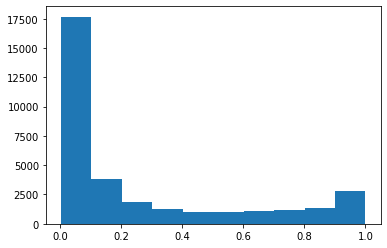

In [656]:
plt.hist(gs.predict_proba(X_train)[:,1])

(array([3295., 3295., 3295., 3295., 3295., 3295., 3295., 3295., 3295.,
        3295.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <a list of 10 Patch objects>)

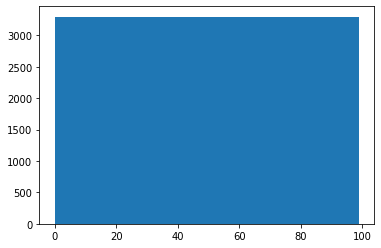

In [660]:
binner = KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='quantile')
plt.hist(binner.fit_transform(gs.predict_proba(X_train)[:,1].reshape(-1,1)))

(array([17669.,  3783.,  1834.,  1231.,  1000.,  1037.,  1130.,  1151.,
         1353.,  2762.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <a list of 10 Patch objects>)

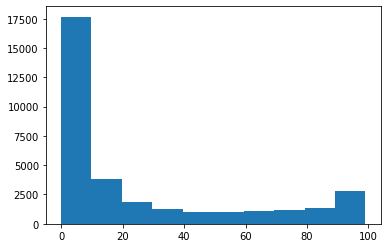

In [661]:
binner = KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='uniform')
plt.hist(binner.fit_transform(gs.predict_proba(X_train)[:,1].reshape(-1,1)))

(array([12805.,  5955.,  2847.,  1866.,  1447.,  1317.,  1426.,  1397.,
         1524.,  2366.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

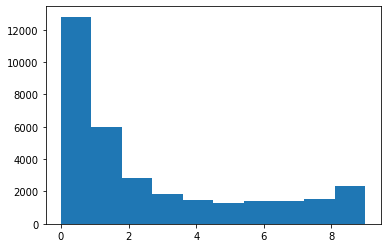

In [680]:
binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
plt.hist(binner.fit_transform(gs.predict_proba(X_train)[:,1].reshape(-1,1)))

In [683]:
binner.fit_transform(gs.predict_proba(X_train)[:,1].reshape(-1,1))

array([[0.],
       [1.],
       [0.],
       ...,
       [9.],
       [1.],
       [3.]])

In [ ]:
sns.barplot(x=gs.predict_proba(X_train)[:,1],
            y=binner.fit_transform(gs.predict_proba(X_train)[:,1].reshape(-1,1)).ravel())

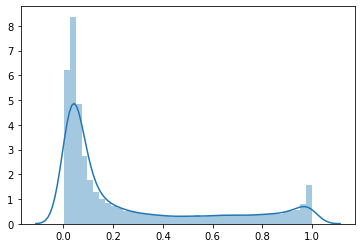

In [667]:
sns.distplot(gs.predict_proba(X_train)[:,1].reshape(-1,1))

In [609]:
gs.cv_results_

{'mean_fit_time': array([ 5.323034  , 13.75394874,  7.99674449]),
 'std_fit_time': array([0.47139887, 2.64847781, 1.68242016]),
 'mean_score_time': array([0.14433866, 0.14370584, 0.14295053]),
 'std_score_time': array([0.00264282, 0.00188425, 0.00360369]),
 'param_classifier': masked_array(data=[LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=1,
                    max_iter=1000, multi_class='warn', n_jobs=10,
                    penalty='elasticnet', random_state=42, solver='saga',
                    tol=0.0001, verbose=0, warm_start=False),
                    LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=1,
                    max_iter=1000, multi_class='warn', n_jobs=10,
                    penalty='elasticnet', random_state=42, solver='saga',
                    tol=0.0001, verbose=0, warm_start=False),
       

In [513]:
gs.best_params_

{'classifier': RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=500, n_jobs=10, oob_score=False,
                        random_state=None, verbose=0, warm_start=False),
 'classifier__class_weight': 'balanced_subsample',
 'feat_pipe__cat__cat_encoder_1': None,
 'feat_pipe__cat__cat_encoder_2': OneHotEncoder(categorical_features=None, categories='auto', drop=None,
               dtype=<class 'numpy.uint8'>, handle_unknown='ignore',
               n_values=None, sparse=False),
 'feat_pipe__num__scaler': None}